# Log-Normal model integration test

Try Log-Normal Model inference on data generated from that model. Should recover synthetic data.

This is the version of the model with between-unit covariance.

## If you want overdispersion in the model:

Set the following to `True`:

In [1]:
overdisp = True

# Generate Test Data

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import lognormal as ln
from fbi import fb_infer
from helpers import *
from autograd import grad
%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(11739)

/home/pearson/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/pearson/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Define model parameters

In [3]:
U = 100  # units
T = 1000  # time points/frames
Kdata = 3  # number of latent states
dt = 1/30  # seconds per frame

## Generate Markov chains

In [4]:
# make transition matrix
A = np.array([[0.98, 0.05], [0.02, 0.95]])

In [5]:
chain = np.empty((T, Kdata))

chain[0, :] = 0  # start all categories "off"
for t in xrange(1, T):
    for k in xrange(Kdata):
        chain[t, k] = stats.bernoulli.rvs(A[1, chain[t - 1, k]])

/home/pearson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


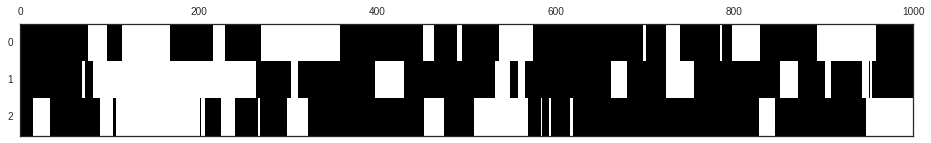

In [6]:
matshow(chain.T);

## Baseline distributions

Scipy parameterizes the log-normal as
$$
\text{log-}\mathcal{N}(x) = \frac{1}{x\sqrt{2\pi \sigma^2}} \exp\left({-\frac{(\log (x/x_0))^2}{2\sigma^2}}\right)
$$ 
from which we can see that $\log x$ is normally distributed with mean $\mu = \log x_0$ and variance $\sigma^2$.

In scipy, $x_0$ is the scale parameter and $\sigma$ is the shape.

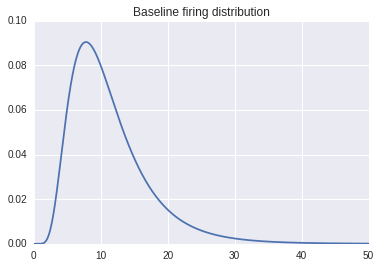

In [7]:
bl_scale = 10
bl_mean = np.log(bl_scale)
bl_sig = 0.5
# baselines should follow a different distribution
bl = stats.norm.rvs(scale=bl_sig, loc=bl_mean, size=U) 

xx = np.linspace(0, 50, 1000)
plt.plot(xx, stats.lognorm.pdf(xx, scale=bl_scale, s=bl_sig))
plt.title('Baseline firing distribution');

## Firing rate effect distributions

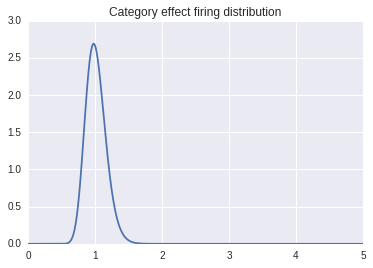

In [8]:
fr_sig = 0.15
fr_scale = 1.
fr_mean = np.log(fr_scale)
lam = stats.norm.rvs(loc=fr_mean, scale=fr_sig, size=(Kdata, U))

xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.lognorm.pdf(xx, scale=fr_scale, s=fr_sig))
plt.title('Category effect firing distribution');

## Overdispersion

We want a covariance matrix $\Sigma_\varepsilon$ that captures (weak) correlations among units. To do this, we construct a correlation matrix $S_\varepsilon$ and then scale each coordinate by $\tau$:

$$
\Sigma_\varepsilon = S \odot (\tau * \tau^\top)
$$

[ 0.05283964  0.11646085  0.04679853  0.13970863  0.07408747  0.03224017
  0.05100436  0.02296162  0.13191726  0.0285772   0.12096115  0.0998616
  0.14124977  0.08721403  0.12197291  0.07615642  0.01036895  0.08796681
  0.00364792  0.10953105  0.06334174  0.1129181   0.03995787  0.09787263
  0.11282489  0.07503071  0.13824246  0.09361197  0.05479611  0.1407809
  0.0707353   0.02420396  0.01742334  0.01827754  0.02379776  0.07848955
  0.12287138  0.03407698  0.02455643  0.02255358  0.06180687  0.03113775
  0.11177889  0.08728737  0.10123846  0.07511091  0.11186748  0.00971889
  0.0147951   0.12929011  0.05264665  0.01040647  0.14236802  0.09200966
  0.11230269  0.14645748  0.10865591  0.07901909  0.05805161  0.1451661
  0.03822902  0.14348172  0.01404257  0.11322598  0.13345244  0.09084699
  0.00260029  0.09772609  0.0551644   0.07695744  0.06440434  0.14940935
  0.10355374  0.08650552  0.0056895   0.04636059  0.08340012  0.0330288
  0.11459362  0.02363745  0.00104405  0.01367694  0.014

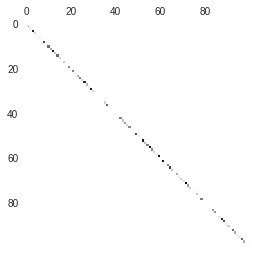

In [9]:
def gencov(U, noise_scale):
    tau = noise_scale * np.random.rand(U)
    S = np.eye(U)
    eps = 0.05
    S += np.diag(eps * np.ones(U - 1), 1)
    S += np.diag(eps * np.ones(U - 1), -1)
    Sig = S * np.outer(tau, tau)
    return tau, Sig
if overdisp:
    noise_scale = 0.15
    tau, Sig = gencov(U, noise_scale)

    print(tau)
    print(Sig)
    plt.matshow(Sig);

## External regressors

In [10]:
# just as above, make a set of Markov-esque regressors

# number of regressors
R = 3  

# "transition matrix" -- want regressors to have some temporal coherence
AX = np.array([[0.98, 0.05], [0.02, 0.95]])

In [11]:
Xchain = np.empty((T, R))

Xchain[0, :] = 0  # start second category off
for t in xrange(1, T):
    for k in xrange(0, R):
        Xchain[t, k] = stats.bernoulli.rvs(AX[1, Xchain[t - 1, k]])

/home/pearson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


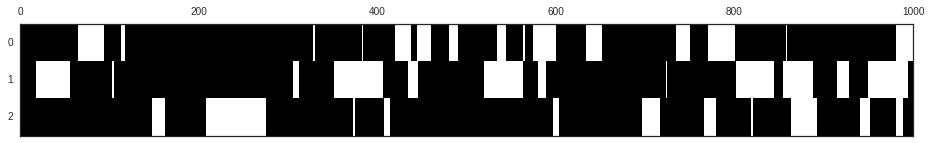

In [12]:
matshow(Xchain.T)

In [13]:
Xf = pd.DataFrame(Xchain, columns=map(lambda x: 'X' + str(x), xrange(R)))
Xf.index.name = 'frame'
Xf = Xf.reset_index()

In [14]:
Xf.head()

,frame,X0,X1,X2
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0


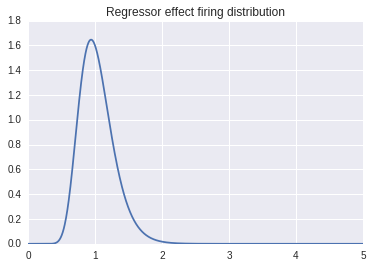

In [15]:
Xfr_scale = 1
Xfr_mean = np.log(Xfr_scale)
Xfr_sig = 0.25
Xlam = stats.norm.rvs(loc=Xfr_mean, scale=Xfr_sig, size=(R, U))

xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.lognorm.pdf(xx, s=Xfr_sig, scale=Xfr_scale))
plt.title('Regressor effect firing distribution');

## Calculate firing rates

Let $\lambda_0$ be the baseline effect, $b_k$ the firing rate effect for latent category $k$ with binary indicator $z_{tk}$ at time $t$, and $\beta_r$ the firing rate effect for external regressor $r$ with value $x_{tr}$ at time $t$. Finally, let $\epsilon_t$ be the overdispersion random effect. Then
$$
\eta_{tu} = \log f_{tu} = \lambda_{0u} + \sum_k z_{tk} b_{ku} + \sum_r x_{tr} \beta_{ru} + \epsilon_t \\
\mathrm{cov}[\epsilon_t] = \Sigma_\varepsilon
$$

In [16]:
# add overdispersion
if overdisp:
    eps = stats.multivariate_normal.rvs(mean=None, cov=Sig, size=(T,))
else:
    eps = 0
    
# calculate firing rate
fr = np.exp(bl + chain.dot(lam) + Xchain.dot(Xlam) + eps) * dt


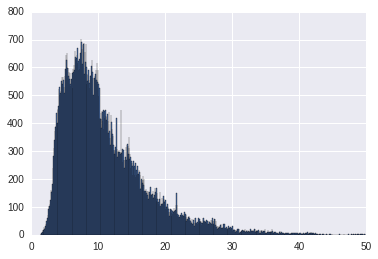

In [17]:
# get a crude sense of population firing
plt.hist(fr.ravel() / dt, bins=1000);
plt.xlim(0, 50);

## Look at generated data

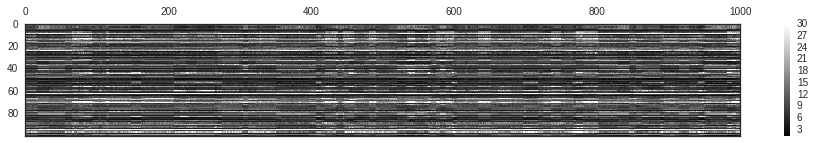

In [18]:
matshow(fr.T / dt, vmax=30);
plt.colorbar();

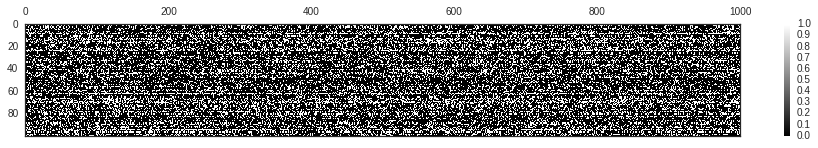

In [19]:
# draw from Poisson
N = stats.poisson.rvs(fr)
matshow(N.T, vmax=1);
plt.colorbar();

In [20]:
# make count frame
df = pd.DataFrame(N)
df.index.name = 'frame'
df = df.reset_index()
df = pd.melt(df, id_vars='frame')
df.columns = ['frame', 'unit', 'count']
df['movie'] = 1

df = df.merge(Xf)

df.head()

,frame,unit,count,movie,X0,X1,X2
0,0,0,0,1,0.0,0.0,0.0
1,0,1,0,1,0.0,0.0,0.0
2,0,2,0,1,0.0,0.0,0.0
3,0,3,0,1,0.0,0.0,0.0
4,0,4,0,1,0.0,0.0,0.0


Finally, convert (frame, movie) pairs to unique times:

In [21]:
df = frames_to_times(df)
M = df.shape[0]
df.head()

,unit,count,X0,X1,X2,time
0,0,0,0.0,0.0,0.0,0
1,1,0,0.0,0.0,0.0,0
2,2,0,0.0,0.0,0.0,0
3,3,0,0.0,0.0,0.0,0
4,4,0,0.0,0.0,0.0,0


# Testing

Just testing out sanity on $\mathcal{L}$.

## Spikes and $\eta$ term

In [22]:
eta_mean = stats.norm.rvs(scale=bl_sig, loc=bl_mean, size=(T, U)) 
eta_cov = np.random.rand(T, U, U)

print(ln.log_observed_spikes(N, eta_mean, eta_cov))

-1386157.93024


## Normal $\mathbb{E}[\log p]$ and entropy

In [23]:
m_a = 0.1  # mean of prior on a
s_a = 0.05**2  # variance of prior on a
mu_a = 0.05 * np.random.randn(U)
sig_a = 0.1 * np.random.rand(U)

print(ln.expected_log_normal(m_a, s_a, mu_a, sig_a))
print(ln.normal_entropy(mu_a, sig_a))

-1268.08006964
-56.2399832674


In [24]:
m_b = 0.1 * np.ones((R,))
S_b = 0.05**2 * np.eye(R)
mu_b = 0.05 * np.random.randn(U, R)
Sig_b = 0.05**2 * np.random.rand(U, R, R)

print(ln.expected_log_mvnormal(m_b, S_b, mu_b, Sig_b))
print(ln.mvnormal_entropy(mu_b, Sig_b))

-823.289251977
-698.577959376


## HMM state sequence and entropy

In [25]:
psi = np.random.rand(T, 1)
log_psi = np.hstack([np.log(psi), 1 - np.log(psi)])
log_A = np.log(A)
log_pi = np.log([0.9, 0.1])
xi, logZ, Xi = fb_infer(A, np.exp(log_pi), np.exp(psi))

print(ln.hmm_entropy(log_psi, log_A, log_pi, xi, Xi, logZ))
print(ln.expected_log_state_sequence(xi, Xi, log_A, log_pi))

793.847077705
-126.678346083


In [26]:
np.tile(xi, (1, 1, 6)).shape

(1, 1000, 12)

## Emission probabilities for Markov Chain

## Entropies and log priors for $A$ and $\pi$

In [27]:
print(ln.dirichlet_entropy(A.T))
print(ln.expected_log_dirichlet(A.T, A.T))

-60.985228435
60.985228435


## Inverse-Gamma for variances:

In [28]:
alpha = 5 * np.random.rand(T, U)
beta = 2 * np.random.rand(T, U)
aa = 3.7 * np.random.rand(T, U)
bb = 5.6 * np.random.rand(T, U)

print(ln.inverse_gamma_entropy(alpha, beta))
print(ln.expected_log_inverse_gamma(aa, bb, alpha, beta))

265599.508953
-909734.428526


## LKJ covariances:

In [29]:
eta = 10
h = 15
print(ln.expected_log_LKJ(h, eta, U))
print(ln.LKJ_entropy(eta, U))

7337.92328772
-7359.66050036


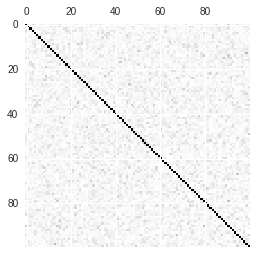

In [30]:
Omega = ln.draw_LKJ(1, U)
plt.matshow(np.abs(Omega))

In [31]:
betas = ln.LKJ_to_beta_pars(1, U)
print(betas)
cpc = 2 * np.random.beta(betas, betas) - 1
print(cpc)
corrvec = ln.corr_from_cpc(cpc)
print(corrvec)

[ 50.5  50.5  50.5 ...,   2.    2.    1.5]
[ 0.08258819  0.00586954 -0.00654709 ..., -0.5355102  -0.07994297
 -0.36359821]
[ 0.08258819  0.00586954 -0.00654709 ...,  0.03842982 -0.03178628
 -0.08339512]


(-1, 1)

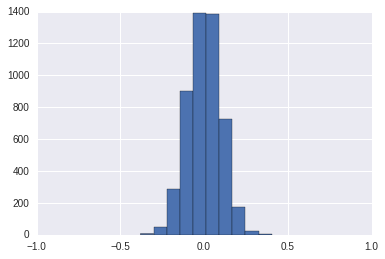

In [32]:
plt.hist(corrvec);
plt.xlim(-1, 1)

# Set up Priors

## Priors on baseline:

We will use a simple model for baseline priors
$$
a_u \sim \mathcal{N}(m_a, s_a^2)
$$
where the actual baseline firing rate is $f = e^{a}$.

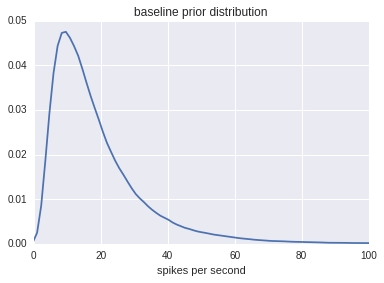

In [33]:
m_a = np.log(15) + np.log(dt)
s_a = 0.7

xx = np.linspace(0, 50, 1000)
samples = np.exp(stats.norm.rvs(loc=m_a, scale=s_a, size=1e5))
sns.kdeplot(samples / dt, clip=(0, 150))
plt.title('baseline prior distribution')
plt.xlim(0, 100);
plt.xlabel('spikes per second');

## Priors on latent firing rate effects:

Here, we adopt a prior
$$
c_{\cdot u} \sim \mathcal{N}(0, S_{c}) \\
$$

In [34]:
# set number of categories to fit
K = 5

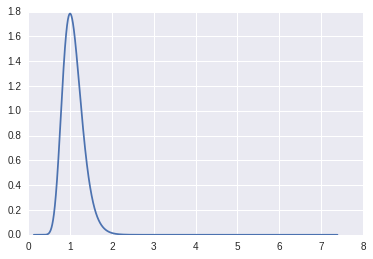

In [35]:
m_c = 0  # prior mean
s_c = 0.05  # std
tau_b = 1/s_c**2
S_c = tau_b * np.eye(K)  # prior cov

xx = np.linspace(-2, 2, 5000)
plt.plot(np.exp(xx), stats.norm.pdf(xx, scale=np.sqrt(s_c)))

## Priors on regression coefficients:

Similar to firing rate effects:

$$
b_{\cdot u} \sim \mathcal{N}(0, S_{b}) \\
$$

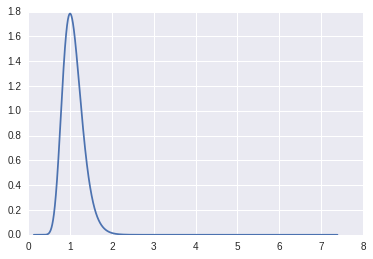

In [36]:
m_b = 0  # prior mean
s_b = 0.05  # std
S_b = s_b * np.eye(R)  # prior cov

xx = np.linspace(-2, 2, 5000)
plt.plot(np.exp(xx), stats.norm.pdf(xx, scale=np.sqrt(s_b)))

## Priors on $A$, $\pi$

In [37]:
###### A ###############
A_off = 10.
A_on = 1.
Avec = np.r_[A_off, A_on].reshape(2, 1, 1)
A_prior = np.tile(Avec, (1, 2, K))

###### pi ###############
pi_off = 15.
pi_on = 1.
pi_prior = np.tile(np.r_[pi_off, pi_on].reshape(2, 1), (1, K))

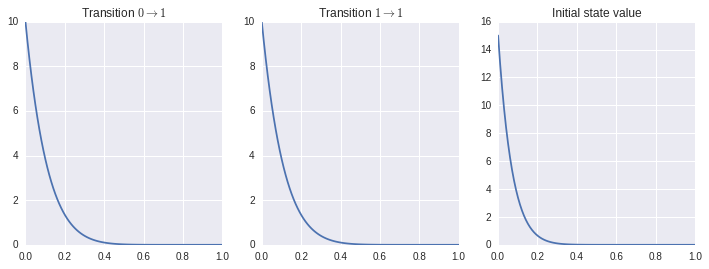

In [38]:
xx = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 0, 0], A_prior[0, 0, 0]))
plt.title(r'Transition $0 \rightarrow 1$');

plt.subplot(1, 3, 2)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 1, 0], A_prior[0, 1, 0]))
plt.title(r'Transition $1 \rightarrow 1$');

plt.subplot(1, 3, 3)
plt.plot(xx, stats.beta.pdf(xx, pi_prior[1, 0], pi_prior[0, 0]))
plt.title('Initial state value');


## Priors on $\Sigma_\varepsilon$ (overdispersion)

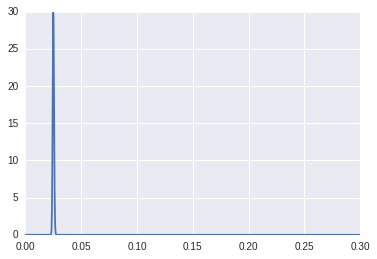

In [39]:
h_eps = 1
eta = 1
m_eps = 40
v_eps = 0.5
a_eps = m_eps**2/v_eps
b_eps = m_eps/v_eps

xx = np.linspace(0, 0.3, 1000)
plt.plot(xx, np.sqrt(stats.invgamma.pdf(xx, a_eps, scale=b_eps)))

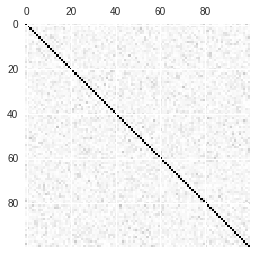

In [40]:
Sig_eps = ln.draw_LKJ(h_eps, U)
    
plt.matshow(np.abs(Sig_eps))

# Initial guesses for posterior parameters

In [41]:
# baseline posteriors
mu_a = (np.log(15) + np.log(dt)) * np.random.randn(U)
sig_a = 0.06 * np.ones(U)
log_sig_a = np.log(sig_a)

In [42]:
# firing rate effects for regressors
mu_b = 0.1 * np.random.randn(U, R)
Sig_b = 0.05 * np.tile(np.eye(R).reshape(1, R, R), (U, 1, 1))
Sig_b_chol = np.linalg.cholesky(Sig_b)

In [43]:
# firing rate effects for latents
mu_c = 0.1 * np.random.randn(U, K)
Sig_c = 0.05 * np.tile(np.eye(K).reshape(1, K, K), (U, 1, 1))
Sig_c_chol = np.linalg.cholesky(Sig_c)

In [44]:
log_A = np.log(np.tile(np.array([0.9, 0.1]).reshape(2, 1, 1), (1, 2, K)))
log_pi = np.log(np.tile(np.array([0.9, 0.1]).reshape(2, 1), (1, K)))
A_post = np.exp(log_A)
pi_post = np.exp(log_pi)

pp = np.random.rand(T, K)
psi = np.stack([pp, 1 - pp], axis=1)
log_psi = np.log(psi)

xi01 = np.random.rand(T, K)
xi0 = np.empty((T, 2, K))
xi0[:, 0, :] = 1 - xi01
xi0[:, 1, :] = xi01

In [45]:
# overdispersion
alpha_eps, beta_eps = 10 * np.ones(U), np.ones(U)
log_alpha_eps = np.log(alpha_eps)
log_beta_eps = np.log(beta_eps)
log_mu_eps = np.log(10 * np.ones(U))
log_ups_eps = np.log(0.02 * np.ones(U))

eta_eps = 2.1
log_eta_eps = np.log(eta_eps - 1)

In [46]:
#etas
# eta_mean = mu_a + Xchain.dot(mu_b.T) + xi0[:, 1, :].dot(mu_c.T)
eta_mean = np.maximum(np.log(N), -2)
eta_scale = 0.01
eta_cov = eta_scale * np.tile(np.eye(U).reshape(1, U, U), (T, 1, 1))
eta_cov_chol = np.linalg.cholesky(eta_cov)

# Initialize $\eta$ and $\overline{\eta}$ by data

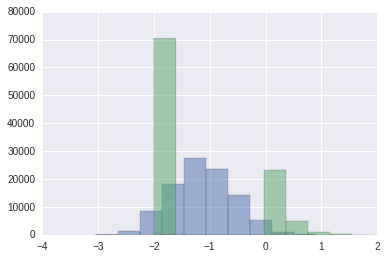

In [47]:
plt.hist(np.log(fr).ravel(), alpha=0.5);
plt.hist(eta_mean.ravel(), alpha=0.5);

## Check $\mathcal{L}$:

In [48]:
%%time
(eta_cov, sig_a, Sig_b, Sig_c, 
     A_post, pi_post, mu_eps, ups_eps, eta_eps) = ln.transform_inputs(
        eta_cov_chol, log_sig_a, Sig_b_chol, Sig_c_chol, 
        log_A, log_pi, log_mu_eps, log_ups_eps, log_eta_eps)
    
ln.L(N, Xchain, m_a, s_a, m_b, S_b, m_c, S_c, 
                      A_prior, pi_prior, h_eps, m_eps, v_eps, 
             eta_mean, eta_cov, mu_a, sig_a, mu_b, Sig_b, mu_c, Sig_c, 
                      log_psi, A_post, pi_post, mu_eps, ups_eps, eta_eps)

CPU times: user 2.16 s, sys: 28 ms, total: 2.19 s
Wall time: 848 ms


## Check $\nabla \mathcal{L}$:

In [49]:
def Lflat(x):
    (eta_mean, eta_cov_chol, mu_a, log_sig_a, mu_b, Sig_b_chol, mu_c, Sig_c_chol, log_psi,
     log_A_post, log_pi_post, log_mu_eps, log_ups_eps, eta_eps) = ln.unpack(x, dimlist)
    
    # transform unconstrained to constrained params
    (eta_cov, sig_a, Sig_b, Sig_c, 
     A_post, pi_post, mu_eps, ups_eps, eta_eps) = ln.transform_inputs(
        eta_cov_chol, log_sig_a, Sig_b_chol, Sig_c_chol, 
        log_A_post, log_pi_post, log_mu_eps, log_ups_eps, log_eta_eps)
    
    L = ln.L(N, Xchain, m_a, s_a, m_b, S_b, m_c, S_c, 
                      A_prior, pi_prior, h_eps, m_eps, v_eps, 
             eta_mean, eta_cov, mu_a, sig_a, mu_b, Sig_b, mu_c, Sig_c, 
                      log_psi, A_post, pi_post, mu_eps, ups_eps, eta_eps)
    return L

In [50]:
xx, dimlist = ln.pack(eta_mean, eta_cov_chol, 
                      mu_a, log_sig_a, 
                      mu_b, Sig_b_chol, 
                      mu_c, Sig_c_chol, 
                      log_psi,
                      log_A, log_pi, 
                      log_mu_eps, log_ups_eps, 
                      log_eta_eps)

In [51]:
xx.shape, dimlist

((10114631,),
 [(1000, 100),
  (1000, 100, 100),
  (100,),
  (100,),
  (100, 3),
  (100, 3, 3),
  (100, 5),
  (100, 5, 5),
  (1000, 2, 5),
  (2, 2, 5),
  (2, 5),
  (100,),
  (100,),
  ()])

In [52]:
%%time
Lflat(xx)

CPU times: user 3.52 s, sys: 92 ms, total: 3.61 s
Wall time: 877 ms


-1121693.240484002

In [53]:
gradL = grad(Lflat)

In [54]:
%%time
gg = gradL(xx)

CPU times: user 23.8 s, sys: 464 ms, total: 24.3 s
Wall time: 15.6 s


## Optimize 

Use RMSprop:

In [55]:
yy = xx.copy()
avg_sq_grad = None

In [88]:
step_size = 0.1
decay = 0.9
eps = 1e-8
nsteps = 200

print(Lflat(yy))
for k in range(nsteps):
    print("Iteration " + str(k))
    gg = gradL(yy)
    if avg_sq_grad is not None:
        avg_sq_grad = avg_sq_grad * decay + gg**2 * (1 - decay)
    else:
        avg_sq_grad = gg ** 2
    yy += step_size * gg / (np.sqrt(avg_sq_grad) + eps)
    print(Lflat(yy))

776697.100576
Iteration 0
782399.130878
Iteration 1
792485.434747
Iteration 2
804546.30188
Iteration 3
810069.034102
Iteration 4
809858.534864
Iteration 5
806119.720892
Iteration 6
806410.945057
Iteration 7
807768.801959
Iteration 8
805778.139522
Iteration 9
803525.247839
Iteration 10
804434.037346
Iteration 11
810438.302528
Iteration 12
809355.065179
Iteration 13
819265.390497
Iteration 14
821583.977936
Iteration 15
822592.751735
Iteration 16
822811.330434
Iteration 17
822873.767337
Iteration 18
824961.567763
Iteration 19
821581.609339
Iteration 20
823420.929022
Iteration 21
827615.132541
Iteration 22
822443.331774
Iteration 23
822575.104955
Iteration 24
826927.816922
Iteration 25
826894.459812
Iteration 26
831792.057807
Iteration 27
832083.530984
Iteration 28
831490.127141
Iteration 29
832974.271078
Iteration 30
833015.045368
Iteration 31
822355.174715
Iteration 32
823804.287744
Iteration 33
827441.25241
Iteration 34
831849.170193
Iteration 35
833100.017502
Iteration 36
833750.078653

In [78]:
pars = ln.unpack(yy, dimlist)

In [79]:
gradvec = ln.unpack(gg, dimlist)

# Assess fit

## State coding

In [80]:
xi_post = ln.get_xi(yy, Xchain, dimlist)

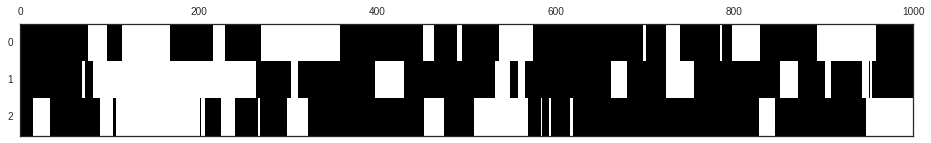

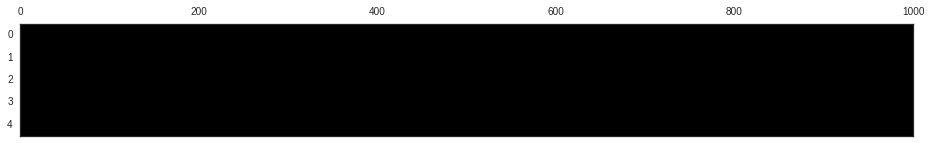

In [81]:
matshow(chain.T, vmin=0, vmax=1);
matshow(xi_post[:, 1, :].T, vmin=0, vmax=1);

## Firing rate variables

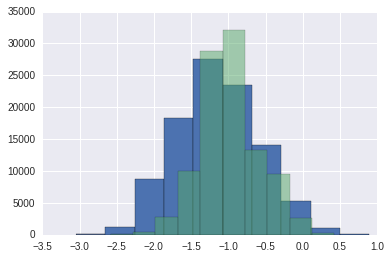

In [82]:
plt.hist(np.log(fr).ravel());
plt.hist(pars[0].ravel(), alpha=0.5);

## Baselines

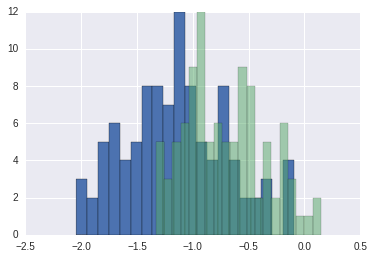

In [83]:
plt.hist(bl + np.log(dt), bins=20);
plt.hist(pars[2], bins=20, alpha=0.5);

## Regression coefficients

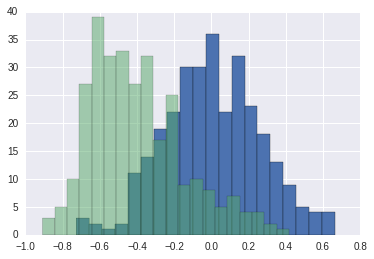

In [84]:
plt.hist(Xlam.ravel(), bins=20);
plt.hist(pars[4].ravel(), bins=20, alpha=0.5);

## HMM firing rate effects

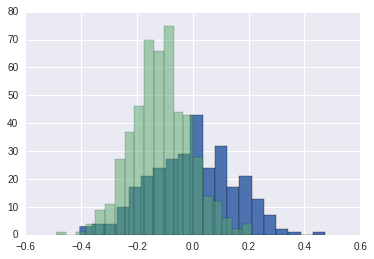

In [85]:
plt.hist(lam.ravel(), bins=20);
plt.hist(pars[6].ravel(), bins=20, alpha=0.5);

## $\log \psi$: start vs finish

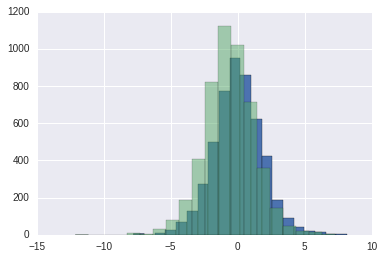

In [86]:
plt.hist(np.diff(log_psi, axis=1).ravel(), bins=20)
plt.hist(np.diff(pars[8], axis=1).ravel(), bins=20, alpha=0.5);

## Noise scale: start vs finish:

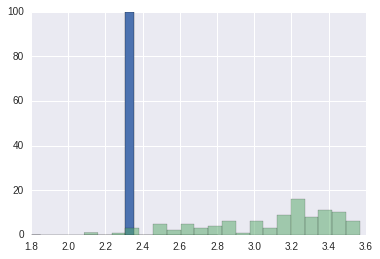

In [87]:
plt.hist(log_mu_eps.ravel(), bins=20)
plt.hist(pars[-3].ravel(), bins=20, alpha=0.5);

# Do inference with random restarts:

In [ ]:
numstarts = 1

In [ ]:
fitobjs = []
Lvals = []
for idx in xrange(numstarts):
    lnm = ln.LogNormalModel(df, K)
    lnm.initialize_baseline(**jitter_inits(baseline_dict, 0.25))
    lnm.initialize_fr_latents(**jitter_inits(fr_latent_dict, 0.25))
    lnm.initialize_latents(**jitter_inits(latent_dict, 0.05))
    lnm.initialize_fr_regressors(**jitter_inits(reg_dict, 0.05))
    if overdisp:
        lnm.initialize_overdispersion(**jitter_inits(od_dict, 0.25))
    lnm.finalize()
    
    print "Start {} -----------------------".format(idx)
    %time lnm.do_inference(tol=1e-4, verbosity=2)
    print "Final L = {}".format(lnm.L())
    Lvals.append(lnm.L())
    fitobjs.append(lnm)

In [ ]:
# pick out best fit
bestind = np.argmax(Lvals)
lnm = fitobjs[bestind]
del fitobjs  # to save memory

# Check results

## Do we correctly recover $z$?

Zoom in on a small part of the time series:

In [ ]:
Trng = (500, 1000)
matshow(chain.T[:, slice(*Trng)], vmin=0, vmax=1);
xi = lnm.nodes['HMM'].nodes['z'].z[1]
matshow(xi.T[:, slice(*Trng)], vmin=0, vmax=1);

What about the whole time series?

In [ ]:
matshow(chain.T, vmin=0, vmax=1);
matshow(xi.T, vmin=0, vmax=1);

In [ ]:
matshow(chain.T);
plt.title('Actual states')
matshow(xi.T, vmin=0, vmax=1);
plt.title('Inferred states')
matshow(fr.T / dt, vmax=30);
plt.title('Actual firing rate')
matshow(N.T, vmin=0, vmax=1);
plt.title('Spike rastergram');

In [ ]:
match = (chain.T.dot(xi) + (1 - chain.T).dot(1 - xi)) / T
mismatch = (chain.T.dot(1 - xi) + (1 - chain.T).dot(xi)) / T
overlap = np.maximum(match, mismatch)

## Calculate overlap between actual and inferred latents

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [ ]:
matshow(overlap, vmin=0, vmax=1)
plt.colorbar();
plt.xlabel('Inferred categories');
plt.ylabel('Actual categories');

In [ ]:
print overlap

## Diagnostics for gamma-distributed variables

Let's look at what we get for $\lambda$, $\theta$, and $\upsilon$:

### Baselines

In [ ]:
plt.figure(figsize=(12, 4))

actual_means = bl
inferred_means = lnm.nodes['baseline'].expected_x() - np.log(dt)

plt.subplot(1, 2, 1)
plt.hist(bl, bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.xlim([0, 5])
plt.title('Baseline firing rates');

plt.subplot(1, 2, 2)
plt.scatter(bl, inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('baseline rates');

### $\lambda$ terms (latents for each unit)

In [ ]:
var_shape = lnm.nodes['fr_latents_prec'].post_shape
var_rate = lnm.nodes['fr_latents_prec'].post_rate

xx = np.linspace(0, 0.1, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=var_shape[kk], scale=var_rate[kk]), label=kk)
plt.title('effect variance posterior');
plt.legend();

In [ ]:
plt.hist(lam.ravel(), bins=50, normed=True, alpha=0.25)
inferred_effects = lnm.nodes['fr_latents'].expected_x().ravel()
plt.hist(inferred_effects, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Firing rate effects');

### $\theta$ terms (overdispersion)

In [ ]:
if overdisp:
    inferred_means = lnm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(eps.ravel(), bins=500, normed=True, alpha=0.25)
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.legend(['actual', 'inferred']);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

In [ ]:
plt.scatter(eps.ravel(), inferred_means, alpha=0.01);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('overdispersion');

### $\upsilon$ terms (regressors)

In [ ]:
inferred_means = lnm.nodes['fr_regressors'].expected_x().ravel()
plt.hist(Xlam.ravel(), bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Regression effects');

In [ ]:
plt.scatter(Xlam.T.ravel(), inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('regression weights');